# Variazione del numero di shot del circuito

In questo notebook prendiamo il NoiseModel costruito nel notebook dedicato e proviamo a confrontare le curve a diversi numeri di circuit shot.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la


from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator, BackendEstimatorV2 as BackendEstimator, BackendSamplerV2 as BackendSampler
from qiskit_ibm_runtime import QiskitRuntimeService
 


from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.noise import (QuantumError, depolarizing_error, amplitude_damping_error, phase_damping_error, pauli_error)
from qiskit.providers import Options


In [4]:
#definiamo l'hamiltoniana
def H_Heis(N):
    #usiamo J = 1
    XX_tuples = [("XX", [i, i + 1], 1) for i in range(0, N-1)]
    YY_tuples = [("YY", [i, i + 1], 1) for i in range(0, N-1)]
    ZZ_tuples = [("ZZ", [i, i + 1], 1) for i in range(0, N-1)]

    #col metodo from_sparse_list di SparsePauliOp definiamo l'hamiltoniana
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples, *ZZ_tuples], N)

    return hamiltonian

#definiamo l'evoluzione temporale nel caso classico
def U_Heis(n_spins,t):
    H = H_Heis(n_spins).to_matrix()
    return la.expm(-1j*t*H)

In [5]:
#Rendiamo generale la funzione, prende N numero di Spin, t il tempo, j il primo spin e i il secondo spin (questi saranno j e j+1 in quanto nearest neighbours)
def R_zz(N, t, j, i):
    
    ZZ_qc = QuantumCircuit(N)

    ZZ_qc.cx(j,i)
    ZZ_qc.rz(2 * t, i) #vedi definizione sopracitata per il fattore 2
    ZZ_qc.cx(j,i)

    return ZZ_qc

#decomponiamo il Rot. Gate XX
def R_xx(N, t, j, i):

    XX_qc = QuantumCircuit(N)

    XX_qc.ry(np.pi/2,[j,i])
    XX_qc.cx(j,i)
    XX_qc.rz(2 * t, i)
    XX_qc.cx(j,i)
    XX_qc.ry(-np.pi/2,[j,i])

    return XX_qc

#decomponiamo il Rot. Gate YY
def R_yy(N, t, j, i):
    YY_qc = QuantumCircuit(N)
    
    YY_qc.rx(np.pi/2,[j,i])
    YY_qc.cx(j,i)
    YY_qc.rz(2 * t, i)
    YY_qc.cx(j,i)
    YY_qc.rx(-np.pi/2,[j,i])

    return YY_qc


def Heisenberg_Trotter(num_spins, trotter_steps, t):
    #definiamo un time step dt
    dt = (t)/(trotter_steps) 

    #creiamo il quantumcircuit
    qc_t = QuantumCircuit(num_spins)

    #iteriamo su ogni time step
    for i in range(trotter_steps):
        #iteriamo su ogni spin
        for j in range(0, num_spins -1):
            #implementazione dei gate è uguale al caso precedente, in quanto operiamo su coppie di spin
            qc_t = qc_t.compose(R_xx(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_yy(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_zz(num_spins,dt,j,j+1))

        
        #qc.barrier()

    return qc_t

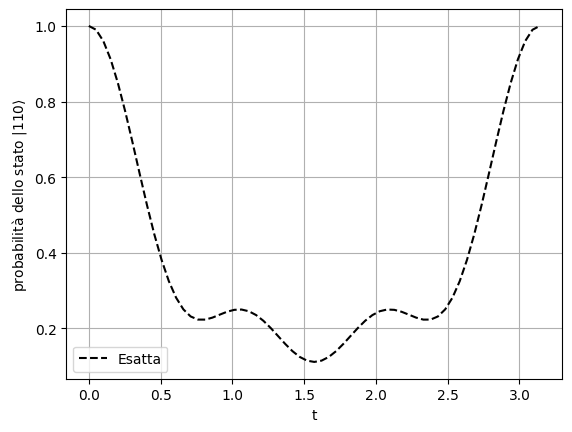

In [6]:
#La curva esatta

#definiamo il numero di time steps
t_steps = 63 #così ogni step è di 0.05

#definiamo il tempo in cui facciamo evolvere il sistema
dt = np.pi

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, pi]
ts = np.linspace(0, dt, t_steps) 
#011
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in ts]

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.legend()
plt.grid()
plt.show()

In [10]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
QiskitRuntimeService.save_account(channel="ibm_quantum", token="982082508a1c98ca02cb712c6751b42ef860d905b080b3bfc02ef35d68d84441803586912cbcf181e1e72ebc8569103421b06c25408fe8134975a72575c4d637", overwrite= True)


fake_backend = FakeManilaV2()
noise_model = NoiseModel.from_backend(fake_backend)

128 circuit shots completed
512 circuit shots completed
1024 circuit shots completed


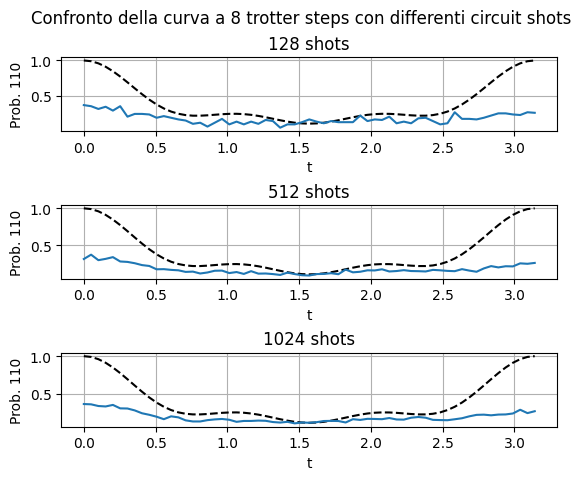

In [11]:
#disegniamo la curva a 8 step variando la precisione dell'estimatore. NB: L'estimatore nelle nuove versioni di qiskit ha cambiato i circuit shot con 
#il parametro "precisione", tuttavia la precisione è legata al numero di circuit shot come 1/sqrt(circuit_shots) pertanto si può comunque maneggiare

#4096 è il numero di circuit shot di default
probs_110_trott = {128:[],512:[],1024:[]}
delta = {128:[],512:[],1024:[]}
simulator = AerSimulator(noise_model=noise_model)
estimator = BackendEstimator(backend=simulator)
pm = generate_preset_pass_manager(optimization_level=0)
for n in probs_110_trott.keys():
    #evolviamo nel tempo
    for sim_t in ts:
        qc = QuantumCircuit(3)
        #buildiamo lo stato
        qc.x(1)
        qc.x(2)
        
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=8,t=sim_t)
        
        qc = qc.compose(trott_steps)

        
        isa_circuit = pm.run(qc)
        isa_observable = prj.apply_layout(isa_circuit.layout)
        cs_precision = 1./(np.sqrt(n)) 
        trotter_result = estimator.run([(isa_circuit, isa_observable)], precision = cs_precision).result()
        trotter_value = trotter_result[0].data.evs
        delta[n].append(np.abs(trotter_value.mean().real - (np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2))) 
        probs_110_trott[n].append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    
    print(str(n)+" circuit shots completed")

#plottiamo
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle(r'Confronto della curva a 8 trotter steps con differenti circuit shots')
#fig.tight_layout()
fig.subplots_adjust(wspace=1, hspace=1)

ax1.plot(ts, probs_110,linestyle="dashed",color="black")
ax1.plot(ts, probs_110_trott[128])
ax1.set_title('128 shots')
ax1.set(xlabel='t', ylabel='Prob. 110')

ax2.plot(ts, probs_110,linestyle="dashed",color="black")
ax2.plot(ts, probs_110_trott[512])
ax2.set_title('512 shots')
ax2.set(xlabel='t', ylabel='Prob. 110')


ax3.plot(ts, probs_110,linestyle="dashed",color="black")
ax3.plot(ts, probs_110_trott[1024])
ax3.set_title('1024 shots')
ax3.set(xlabel='t', ylabel='Prob. 110')
      
ax1.grid()
ax2.grid()
ax3.grid()
plt.savefig('../../png/parameters_change/circuit_shots.png')
plt.show()

## COMMENTO

Variare il numero di circuit shots non varia l'andamento qualitativo della curva, tuttavia si nota come la qualità dell'approssimazione aumenti mediando su un numero maggiore di circuit shots. Si nota che la curva a 128 shots presenta dei picchi ed un andamento frastagliato, mentre aumentando il numero di shots la curva diviene liscia e approssima meglio la curva esatta.
Plottando la differenza tra il valore simulato e quello esatto si nota come la curva a 128 steps abbia dei picchi d'errore, ma tutte e tre le curve sono distanti dal valore esatto alla fine del circuito di circa 0.4

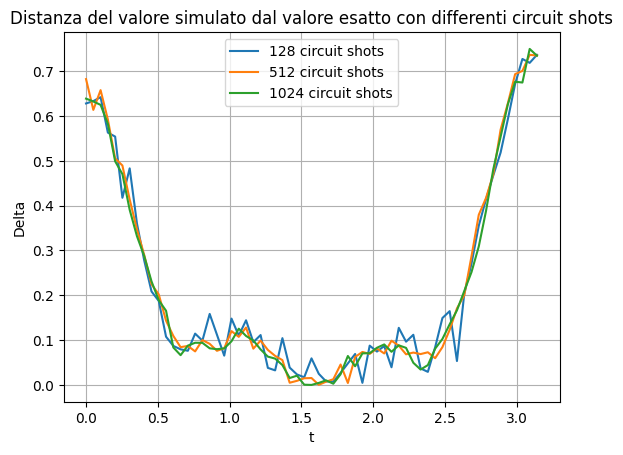

In [12]:
for (i,n) in enumerate(delta.keys()):
    plt.plot(ts, delta[n],color="C"+str(i),label=str(n)+" circuit shots")
plt.xlabel('t')
plt.ylabel(r'Delta')
plt.title(r'Distanza del valore simulato dal valore esatto con differenti circuit shots')
plt.legend()
plt.grid()
plt.savefig('../../png/parameters_change/delta_circuit_shots.png')
plt.show()